# **1. CGRTool**

In [1]:
import sys
sys.path.append('../../')
from SynTemp.SynUtils.utils import load_database, save_database
import pandas as pd

uspto_3k = pd.read_csv('../../Data/AAM/aam_benchmark/USPTO_sampled.csv')

## 1.1 Generate unbias ground truth

In [5]:
import pandas as pd
import re

def add_ground_truth_column(df):
    # Precompile the regex pattern outside of the function to avoid recompilation
    atom_map_pattern = re.compile(r':\d+')

    # Helper function to count atom mappings
    def count_atom_mappings(smiles_string):
        if pd.isna(smiles_string):
            return 0
        mappings = atom_map_pattern.findall(smiles_string)
        return len(set(mappings))

    # Vectorize the counting of atom mappings for each mapper based on the correct flag
    for mapper in ['RXNMapper', 'GraphMapper', 'LocalMapper']:
        df[mapper + '_count'] = df.apply(lambda x: count_atom_mappings(x[mapper]) if x[mapper + '_correct'] else 0, axis=1)

    # Function to determine the ground truth based on the highest count of atom mappings
    def determine_ground_truth(row):
        # Collect counts and corresponding SMILES strings if the count is positive
        mapping_data = {
            'RXNMapper': (row['RXNMapper_count'], row['RXNMapper']),
            'GraphMapper': (row['GraphMapper_count'], row['GraphMapper']),
            'LocalMapper': (row['LocalMapper_count'], row['LocalMapper'])
        }
        # Select the mapper with the highest non-zero count
        max_mapper, (max_count, max_smiles) = max(mapping_data.items(), key=lambda x: x[1][0], default=(None, (0, None)))
        # Return the SMILES string of the mapper with the highest count or None if all counts are zero
        return max_smiles if max_count > 0 else None

    # Apply the function to determine the ground truth for each row
    df['Ground Truth'] = df.apply(determine_ground_truth, axis=1)
    return df

In [6]:
df = add_ground_truth_column(uspto_3k)
df.to_csv('../../Data/AAM/cgrtool_benchmark/USPTO_3K.csv', index=False)

## 1.2. Benchmark with CGRTool

In [2]:
df_old = pd.read_csv('../../Data/AAM/cgrtool_benchmark/uspto_3k_cgrtool_old.csv', index_col=0)
df_new = pd.read_csv('../../Data/AAM/cgrtool_benchmark/uspto_3k_cgrtool_new.csv', index_col=0)

In [3]:
df_old = df_old[['Ground Truth', 'RXNMapper_correct','GraphMapper_correct','LocalMapper_correct',
                 'CGRTool_rxnmapper', 'CGRTool_graphmapper', 'CGRTool_localmapper']]

df_new = df_new[['Ground Truth', 'RXNMapper_correct','GraphMapper_correct','LocalMapper_correct',
                 'CGRTool_rxnmapper', 'CGRTool_graphmapper', 'CGRTool_localmapper']]



In [44]:
df_new.iloc[609,:]['RXNMapper']

'CCO.O=C(OCc1ccccc1)[NH:7][C:6]1([PH:8](=[O:9])[NH:10][C:11](=[O:12])[CH2:13][O:14][c:15]2[cH:16][cH:17][cH:18][cH:19][cH:20]2)[CH2:5][CH2:4][CH2:3][N:2]([NH2:1])[C:21]1=[O:22]>>[NH2:1][N:2]1[CH2:3][CH2:4][CH2:5][C:6]([NH2:7])([PH:8](=[O:9])[NH:10][C:11](=[O:12])[CH2:13][O:14][c:15]2[cH:16][cH:17][cH:18][cH:19][cH:20]2)[C:21]1=[O:22]'

In [46]:
df_new.iloc[609,:]['GroundTruth']

'[CH2:2]([CH3:1])[OH:3].[cH:30]1[cH:29][c:28]([cH:33][cH:32][cH:31]1)[O:27][CH2:26][C:24](=[O:25])[NH:23][P:21](=[O:22])[C:9]2([C:34](=[O:35])[N:5]([NH2:4])[CH2:6][CH2:7][CH2:8]2)[NH:10][C:11](=[O:12])[O:13][CH2:14][c:15]3[cH:16][cH:17][cH:18][cH:19][cH:20]3>>[cH:30]1[cH:29][c:28]([cH:33][cH:32][cH:31]1)[O:27][CH2:26][C:24](=[O:25])[NH:23][P:21]([C:9]2([CH2:8][CH2:7][CH2:6][N:5]([C:34]2=[O:35])[NH2:4])[NH2:10])=[O:22]'

In [4]:
ground_data = pd.DataFrame([{'RXNMapper': round(100*df_old['RXNMapper_correct'].sum()/len(df_old), 2),
                'Graphormer': round(100*df_old['GraphMapper_correct'].sum()/len(df_old), 2),
                'LocalMapper': round(100*df_old['LocalMapper_correct'].sum()/len(df_old), 2),}]).T
ground_data.rename(columns={0:'Ground Truth (%)'}, inplace=True)
ground_data

,Ground Truth (%)
RXNMapper,93.53
Graphormer,95.10
LocalMapper,100.00


In [69]:
cgrtool_old = pd.DataFrame([{'RXNMapper': round(100*df_old['CGRTool_rxnmapper'].sum()/len(df_old), 2),
                'Graphormer': round(100*df_old['CGRTool_graphmapper'].sum()/len(df_old), 2),
                'LocalMapper': round(100*df_old['CGRTool_localmapper'].sum()/len(df_old), 2),}]).T

cgrtool_old.rename(columns={0:'CGRTools 1 (%)'}, inplace=True)
cgrtool_old

,CGRTools 1 (%)
RXNMapper,92.63
Graphormer,93.20
LocalMapper,100.00


In [68]:
cgrtool_new = pd.DataFrame([{'RXNMapper': round(100*df_new['CGRTool_rxnmapper'].sum()/len(df_new), 2),
                'Graphormer': round(100*df_new['CGRTool_graphmapper'].sum()/len(df_new), 2),
                'LocalMapper': round(100*df_new['CGRTool_localmapper'].sum()/len(df_new), 2),}]).T

cgrtool_new.rename(columns={0:'CGRTools 2 (%)'}, inplace=True)
cgrtool_new

,CGRTools 2 (%)
RXNMapper,91.27
Graphormer,95.10
LocalMapper,98.10


In [70]:
cgr_data = pd.concat([ground_data, cgrtool_old, cgrtool_new], axis =1)
cgr_data

,Ground Truth (%),CGRTools 1 (%),CGRTools 2 (%)
RXNMapper,93.53,92.63,91.27
Graphormer,95.10,93.20,95.10
LocalMapper,100.00,100.00,98.10


In [5]:
from SynTemp.SynAAM.aam_validator import AMMValidator
df_old = pd.read_csv('../../Data/AAM/cgrtool_benchmark/uspto_3k_cgrtool_old.csv', index_col=0)
df_new = pd.read_csv('../../Data/AAM/cgrtool_benchmark/uspto_3k_cgrtool_new.csv', index_col=0)
results_old_its = AMMValidator.validate_smiles(
        data=df_old,
        ground_truth_col="GroundTruth",
        mapped_cols=["RXNMapper", "GraphMapper", "LocalMapper"],
        check_method="ITS",
        ignore_aromaticity=False,
        n_jobs=4,
        verbose=0,
        ensemble=False,
        strategies=[["rxn_mapper", "graphormer", "local_mapper"]],
        ignore_tautomers=False
    )


results_new_its = AMMValidator.validate_smiles(
        data=df_new,
        ground_truth_col="GroundTruth",
        mapped_cols=["RXNMapper", "GraphMapper", "LocalMapper"],
        check_method="ITS",
        ignore_aromaticity=False,
        n_jobs=4,
        verbose=0,
        ensemble=False,
        strategies=[["rxn_mapper", "graphormer", "local_mapper"]],
        ignore_tautomers=False
    )

[13:26:19] Can't kekulize mol.  Unkekulized atoms: 26 30
[13:26:19] WARNING: not removing hydrogen atom without neighbors
[13:26:19] WARNING: not removing hydrogen atom without neighbors
[13:26:19] WARNING: not removing hydrogen atom without neighbors
[13:26:19] WARNING: not removing hydrogen atom without neighbors
[13:26:19] WARNING: not removing hydrogen atom without neighbors
[13:26:19] WARNING: not removing hydrogen atom without neighbors
[13:26:19] WARNING: not removing hydrogen atom without neighbors
[13:26:19] WARNING: not removing hydrogen atom without neighbors
[13:26:19] WARNING: not removing hydrogen atom without neighbors
[13:26:19] WARNING: not removing hydrogen atom without neighbors
[13:26:19] WARNING: not removing hydrogen atom without neighbors
[13:26:19] WARNING: not removing hydrogen atom without neighbors
[13:26:20] WARNING: not removing hydrogen atom without neighbors
[13:26:20] WARNING: not removing hydrogen atom without neighbors
[13:26:20] WARNING: not removing 

In [6]:
from SynTemp.SynAAM.aam_validator import AMMValidator
df_old = pd.read_csv('../../Data/AAM/cgrtool_benchmark/uspto_3k_cgrtool_old.csv', index_col=0)
df_new = pd.read_csv('../../Data/AAM/cgrtool_benchmark/uspto_3k_cgrtool_new.csv', index_col=0)
results_old = AMMValidator.validate_smiles(
        data=df_old,
        ground_truth_col="GroundTruth",
        mapped_cols=["RXNMapper", "GraphMapper", "LocalMapper"],
        check_method="RC",
        ignore_aromaticity=False,
        n_jobs=4,
        verbose=0,
        ensemble=False,
        strategies=[["rxn_mapper", "graphormer", "local_mapper"]],
        ignore_tautomers=False
    )


results_new = AMMValidator.validate_smiles(
        data=df_new,
        ground_truth_col="GroundTruth",
        mapped_cols=["RXNMapper", "GraphMapper", "LocalMapper"],
        check_method="RC",
        ignore_aromaticity=False,
        n_jobs=4,
        verbose=0,
        ensemble=False,
        strategies=[["rxn_mapper", "graphormer", "local_mapper"]],
        ignore_tautomers=False
    )

[13:30:09] Can't kekulize mol.  Unkekulized atoms: 26 30
[13:30:09] WARNING: not removing hydrogen atom without neighbors
[13:30:09] WARNING: not removing hydrogen atom without neighbors
[13:30:09] WARNING: not removing hydrogen atom without neighbors
[13:30:09] WARNING: not removing hydrogen atom without neighbors
[13:30:09] WARNING: not removing hydrogen atom without neighbors
[13:30:09] WARNING: not removing hydrogen atom without neighbors
[13:30:09] WARNING: not removing hydrogen atom without neighbors
[13:30:09] WARNING: not removing hydrogen atom without neighbors
[13:30:09] WARNING: not removing hydrogen atom without neighbors
[13:30:09] WARNING: not removing hydrogen atom without neighbors
[13:30:09] WARNING: not removing hydrogen atom without neighbors
[13:30:09] WARNING: not removing hydrogen atom without neighbors
[13:30:10] WARNING: not removing hydrogen atom without neighbors
[13:30:10] WARNING: not removing hydrogen atom without neighbors
[13:30:10] WARNING: not removing 

In [31]:
pd.DataFrame(results_new_its[0])

,mapper,accuracy,results,success_rate
0,RXNMapper,93.50,"[True, True, True, True, True, True, True, Tru...",100.0
1,GraphMapper,95.10,"[True, True, True, True, True, True, True, Tru...",100.0
2,LocalMapper,99.97,"[True, True, True, True, True, True, True, Tru...",100.0


In [36]:
import numpy as np
np.sum(results_new_its[0][0]['results'])

2805

In [39]:
np.sum(results_new[0][0]['results'])

2806

In [32]:
pd.DataFrame(results_new[0])

,mapper,accuracy,results,success_rate
0,RXNMapper,93.53,"[True, True, True, True, True, True, True, Tru...",100.0
1,GraphMapper,95.10,"[True, True, True, True, True, True, True, Tru...",100.0
2,LocalMapper,100.00,"[True, True, True, True, True, True, True, Tru...",100.0


In [26]:
pd.DataFrame(results_new_its[0][0]['results']) != pd.DataFrame(results_new[0][0]['results'])

,0
0,False
1,False
2,False
3,False
4,False
...,...
2995,False
2996,False
2997,False
2998,False


In [40]:
wrong_index = []
for key, value in enumerate(results_new[0][0]['results']):
    if value != results_new_its[0][0]['results'][key]:
        print(value)
        wrong_index.append(key)


True


In [41]:
wrong_index

[609]

In [27]:
results_new[0][0]['results']

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True

In [ ]:
aam_new = pd.DataFrame(results_new[0])[['mapper','accuracy']]
aam_new['mapper'][1] = 'Graphormer'

In [ ]:
aam_new = pd.DataFrame(results_new[0])[['mapper','accuracy']]
aam_new['mapper'][1] = 'Graphormer'
aam_new.index = aam_new['mapper'].tolist()
aam_new.drop(['mapper'], axis=1, inplace = True)
aam_new.rename(columns={'accuracy':'SynTemp 2 (%)'}, inplace=True)

In [91]:
aam_new

,SynTemp 2 (%)
RXNMapper,93.53
Graphormer,95.10
LocalMapper,100.00


In [ ]:
aam_old = pd.DataFrame(results_old[0])[['mapper','accuracy']]
aam_old['mapper'][1] = 'Graphormer'
aam_old.index = aam_old['mapper'].tolist()
aam_old.drop(['mapper'], axis=1, inplace = True)
aam_old.rename(columns={'accuracy':'SynTemp 1 (%)'}, inplace=True)

In [93]:
benchmark = pd.concat([cgr_data,aam_old,aam_new], axis=1)   

In [94]:
benchmark

,Ground Truth (%),CGRTools 1 (%),CGRTools 2 (%),SynTemp 1 (%),SynTemp 2 (%)
RXNMapper,93.53,92.63,91.27,93.53,93.53
Graphormer,95.10,93.20,95.10,95.10,95.10
LocalMapper,100.00,100.00,98.10,100.00,100.00


### 1.2.2. EEquaam

In [ ]:
from SynTemp.SynChemistry.balance_checker import BalanceReactionCheck
df_old = pd.read_csv('../../Data/AAM/cgrtool_benchmark/uspto_3k_cgrtool_old.csv', index_col=0)
df_new = pd.read_csv('../../Data/AAM/cgrtool_benchmark/uspto_3k_cgrtool_new.csv', index_col=0)
check_balance = BalanceReactionCheck()
df_new_balance, _ = check_balance.dicts_balance_check(df_new.to_dict('records'), 'GroundTruth')

df_old_balance, _ = check_balance.dicts_balance_check(df_old.to_dict('records'), 'GroundTruth')

In [18]:
from SynTemp.SynAAM.aam_validator import AMMValidator

In [19]:
results_old_aam,_ = AMMValidator.validate_smiles(
        data=df_old_balance,
        ground_truth_col="GroundTruth",
        mapped_cols=["RXNMapper", "GraphMapper", "LocalMapper"],
        check_method="RC",
        ignore_aromaticity=False,
        n_jobs=4,
        verbose=0,
        ensemble=False,
        strategies=[["rxn_mapper", "graphormer", "local_mapper"]],
        ignore_tautomers=False
    )


results_new_aam,_ = AMMValidator.validate_smiles(
        data=df_new_balance,
        ground_truth_col="GroundTruth",
        mapped_cols=["RXNMapper", "GraphMapper", "LocalMapper"],
        check_method="RC",
        ignore_aromaticity=False,
        n_jobs=4,
        verbose=0,
        ensemble=False,
        strategies=[["rxn_mapper", "graphormer", "local_mapper"]],
        ignore_tautomers=False
    )

In [21]:
pd.DataFrame(results_old_aam)

,mapper,accuracy,results,success_rate
0,RXNMapper,100.0,"[True, True, True, True, True, True, True, Tru...",100.0
1,GraphMapper,100.0,"[True, True, True, True, True, True, True, Tru...",100.0
2,LocalMapper,100.0,"[True, True, True, True, True, True, True, Tru...",100.0


In [22]:
pd.DataFrame(results_new_aam)

,mapper,accuracy,results,success_rate
0,RXNMapper,100.0,"[True, True, True, True, True, True, True, Tru...",100.0
1,GraphMapper,100.0,"[True, True, True, True, True, True, True, Tru...",100.0
2,LocalMapper,100.0,"[True, True, True, True, True, True, True, Tru...",100.0


In [20]:
results_old_eqquaam,_ = AMMValidator.validate_smiles(
        data=df_old_balance,
        ground_truth_col="GroundTruth",
        mapped_cols=["RXNMapper", "GraphMapper", "LocalMapper"],
        check_method="ITS",
        ignore_aromaticity=False,
        n_jobs=4,
        verbose=0,
        ensemble=False,
        strategies=[["rxn_mapper", "graphormer", "local_mapper"]],
        ignore_tautomers=True
    )


results_new_eqquaam,_ = AMMValidator.validate_smiles(
        data=df_new_balance,
        ground_truth_col="GroundTruth",
        mapped_cols=["RXNMapper", "GraphMapper", "LocalMapper"],
        check_method="ITS",
        ignore_aromaticity=False,
        n_jobs=4,
        verbose=0,
        ensemble=False,
        strategies=[["rxn_mapper", "graphormer", "local_mapper"]],
        ignore_tautomers=True
    )

In [24]:
pd.DataFrame(results_new_eqquaam)

,mapper,accuracy,results,success_rate
0,RXNMapper,100.0,"[True, True, True, True, True, True, True, Tru...",100.0
1,GraphMapper,100.0,"[True, True, True, True, True, True, True, Tru...",100.0
2,LocalMapper,100.0,"[True, True, True, True, True, True, True, Tru...",100.0


## 1.3. Analyze difference from Ground Truth

In [104]:
data_check = pd.DataFrame(results_new[0])

In [105]:
list_diff_rxn= []
for key, value in enumerate(df_new['RXNMapper_correct']):
    if value != data_check['results'][0][key]:
        list_diff_rxn.append(key)

list_diff_graph= []
for key, value in enumerate(df_new['GraphMapper_correct']):
    if value != data_check['results'][1][key]:
        list_diff_graph.append(key)
print('Differences in RXNMapper:', list_diff_rxn)
print('Differences in GraphMapper:', list_diff_graph)
        

Differences in RXNMapper: [192, 2157]
Differences in GraphMapper: []


[15:41:02] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 1 3 17 18 19 14 
[15:41:02] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 1 3 17 18 19 14 
[15:41:02] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 1 3 17 18 19 14 


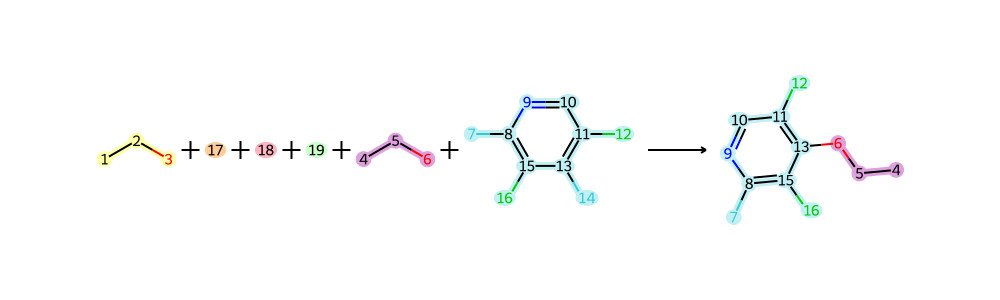

[15:41:02] reactant 1 has no mapped atoms.
[15:41:02] reactant 3 has no mapped atoms.
[15:41:02] reactant 4 has no mapped atoms.
[15:41:02] reactant 5 has no mapped atoms.
[15:41:02] reactant 1 has no mapped atoms.
[15:41:02] reactant 3 has no mapped atoms.
[15:41:02] reactant 4 has no mapped atoms.
[15:41:02] reactant 5 has no mapped atoms.
[15:41:02] reactant 1 has no mapped atoms.
[15:41:02] reactant 3 has no mapped atoms.
[15:41:02] reactant 4 has no mapped atoms.
[15:41:02] reactant 5 has no mapped atoms.


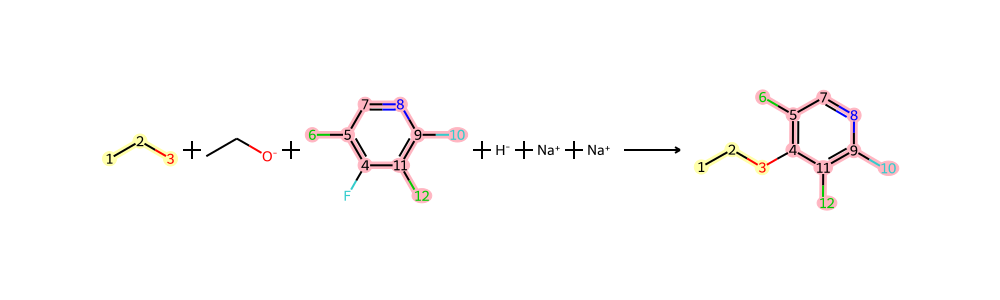

True


In [110]:
from SynTemp.SynVis.chemical_reaction_visualizer import ChemicalReactionVisualizer

vis = ChemicalReactionVisualizer()
i = 192
display(vis.visualize_reaction(df_new.loc[i,'GroundTruth'], img_size=(1000, 300), show_atom_map=True))
display(vis.visualize_reaction(df_new.loc[i,'RXNMapper'], img_size=(1000, 300), show_atom_map=True))
print(df_new.loc[i,'RXNMapper_correct'])

[15:41:51] reactant 1 has no mapped atoms.
[15:41:51] reactant 2 has no mapped atoms.
[15:41:51] reactant 1 has no mapped atoms.
[15:41:51] reactant 2 has no mapped atoms.
[15:41:51] reactant 1 has no mapped atoms.
[15:41:51] reactant 2 has no mapped atoms.


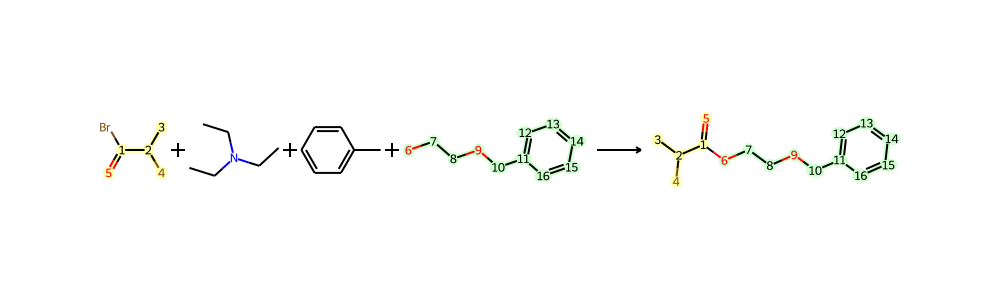

[15:41:51] reactant 1 has no mapped atoms.
[15:41:51] reactant 2 has no mapped atoms.
[15:41:51] reactant 1 has no mapped atoms.
[15:41:51] reactant 2 has no mapped atoms.
[15:41:51] reactant 1 has no mapped atoms.
[15:41:51] reactant 2 has no mapped atoms.


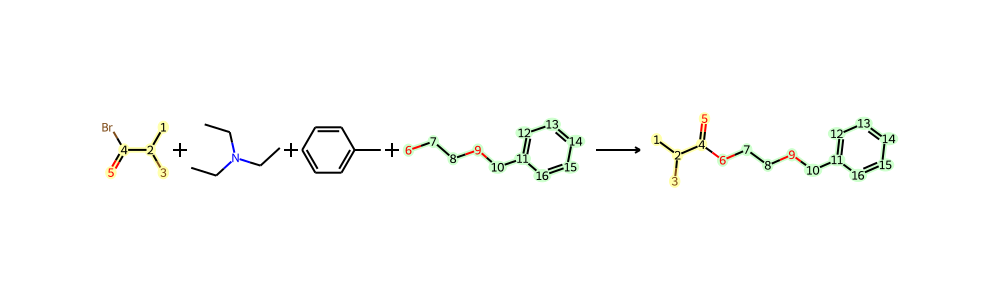

False


In [112]:
i = 2157
display(vis.visualize_reaction(df_new.loc[i,'GroundTruth'], img_size=(1000, 300), show_atom_map=True))
display(vis.visualize_reaction(df_new.loc[i,'RXNMapper'], img_size=(1000, 300), show_atom_map=True))
print(df_new.loc[i,'RXNMapper_correct'])

In [107]:
df_new.loc[i,'RXNMapper']

'[CH3:1][CH2:2][OH:3].CC[O-].F[c:4]1[c:5]([Cl:6])[cH:7][n:8][c:9]([F:10])[c:11]1[Cl:12].[H-].[Na+].[Na+]>>[CH3:1][CH2:2][O:3][c:4]1[c:5]([Cl:6])[cH:7][n:8][c:9]([F:10])[c:11]1[Cl:12]'

In [10]:
reaction_smiles = [df_new.loc[192,'GroundTruth'], df_new.loc[192,'RXNMapper'],
                   df_new.loc[2157,'GroundTruth'], df_new.loc[2157,'RXNMapper']]
subtitles = ["A", "B", "C", "D"]

In [84]:
import io
import rdkit.Chem.rdmolfiles as rdmolfiles
import rdkit.Chem.Draw.rdMolDraw2D as rdMolDraw2D
import rdkit.Chem.rdChemReactions as rdChemReactions
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.backends.backend_pdf

from PIL import Image
from synrbl.SynUtils.chem_utils import remove_atom_mapping, normalize_smiles


class RxnVis:
    def __init__(
        self,
        nrows=1,
        ncols=1,
        dpi=400,
        figsize=(16, 9),
        cairosize=(1600, 900),
        border=10,
        show=True,
        remove_aam=False,
        normalize=False,
        close_fig=True,
    ):
        self.nrows = nrows
        self.ncols = ncols
        self.dpi = dpi
        self.figsize = figsize
        self.cairosize = cairosize
        self.border = border
        self.show = show
        self.remove_aam = remove_aam
        self.normalize = normalize
        self.close_fig = close_fig

    def get_rxn_img(self, smiles):
        drawer = rdMolDraw2D.MolDraw2DCairo(*self.cairosize)
        opts = drawer.drawOptions()
        opts.scale = 1
        opts.bondLineWidth = 8
        opts.atomLabelFontSize = 50
        opts.padding = 0.1
        if ">>" in smiles:
            rxn = rdChemReactions.ReactionFromSmarts(smiles, useSmiles=True)
            drawer.DrawReaction(rxn)
        else:
            mol = rdmolfiles.MolFromSmiles(smiles)
            if mol is None:
                mol = rdmolfiles.MolFromSmarts(smiles)
            drawer.DrawMolecule(mol)
        drawer.FinishDrawing()
        img = Image.open(io.BytesIO(drawer.GetDrawingText()))
        nonwhite_positions = [
            (x, y)
            for x in range(img.size[0])
            for y in range(img.size[1])
            if img.getdata()[x + y * img.size[0]] != (255, 255, 255)  # type: ignore
        ]
        rect = (
            min([x - self.border for x, y in nonwhite_positions]),
            min([y - self.border for x, y in nonwhite_positions]),
            max([x + self.border for x, y in nonwhite_positions]),
            max([y + self.border for x, y in nonwhite_positions]),
        )
        return img.crop(rect)

    def __parse_input(self, smiles, titles):
        if isinstance(smiles, str):
            smiles = [smiles]
        if titles is None:
            titles = [None for _ in range(len(smiles))]
        return smiles, titles

    def __get_fig(self):
        fig, axs = plt.subplots(
            self.nrows, self.ncols, dpi=self.dpi, figsize=self.figsize
        )
        if self.ncols * self.nrows == 1:
            axs = [[axs]]
        elif self.nrows == 1:
            axs = [axs]
        elif self.ncols == 1:
            axs = [[a] for a in axs]
        return fig, axs

    def __get_ax(self, axs, i, title=None):
        i_r = int(i / self.ncols)
        i_c = int(i % self.ncols)
        ax = axs[i_r][i_c]
        if title is not None:
            ax.set_title(title)
        ax.axis("off")
        return ax

    def plot(
        self,
        smiles: str | list[str],
        titles=None,
        savefig=None,
        show=None,
        remove_aam=None,
        normalize=None,
        close_fig=None,
    ):
        smiles, titles = self.__parse_input(smiles, titles)
        show = show if show is not None else self.show
        remove_aam = remove_aam if remove_aam is not None else self.remove_aam
        normalize = normalize if normalize is not None else self.normalize
        close_fig = close_fig if close_fig is not None else self.close_fig

        if normalize:
            smiles = [normalize_smiles(s) for s in smiles]
        elif remove_aam:
            smiles = [remove_atom_mapping(s) for s in smiles]

        fig, axs = self.__get_fig()
        for i, (s, t) in enumerate(zip(smiles, titles)):
            if i == self.nrows * self.ncols:
                print(
                    "[WARN] {} reactions will not be displayed.".format(len(smiles) - i)
                )
                break
            ax = self.__get_ax(axs, i, title=t)
            if s is not None and len(s) > 0:
                img = self.get_rxn_img(s)
                ax.imshow(img)
        #fig.tight_layout()
        if savefig is not None:
            fig.savefig(savefig)
        if show is True:
            plt.show()
        elif close_fig:
            plt.close(fig)
            fig = None
        return fig, axs



class Rxn2Pdf:
    def __init__(self, file, **kwargs):
        kwargs = Rxn2Pdf.__override_kwargs(**kwargs)
        self.rxnvis = RxnVis(**kwargs)
        self.pdf = matplotlib.backends.backend_pdf.PdfPages(file)

    @staticmethod
    def __override_kwargs(**kwargs):
        kwargs["close_fig"] = False
        kwargs["show"] = False
        return kwargs

    def add(self, smiles, **kwargs):
        if self.pdf is None:
            raise RuntimeError("Pdf is already closed.")
        kwargs = Rxn2Pdf.__override_kwargs(**kwargs)
        fig, _ = self.rxnvis.plot(smiles, **kwargs)
        self.pdf.savefig(fig)
        plt.close(fig)

    def close(self):
        if self.pdf is None:
            raise RuntimeError("Pdf is already closed.")
        self.pdf.close()
        self.pdf = None

In [85]:
import seaborn as sns
sns.set_theme()

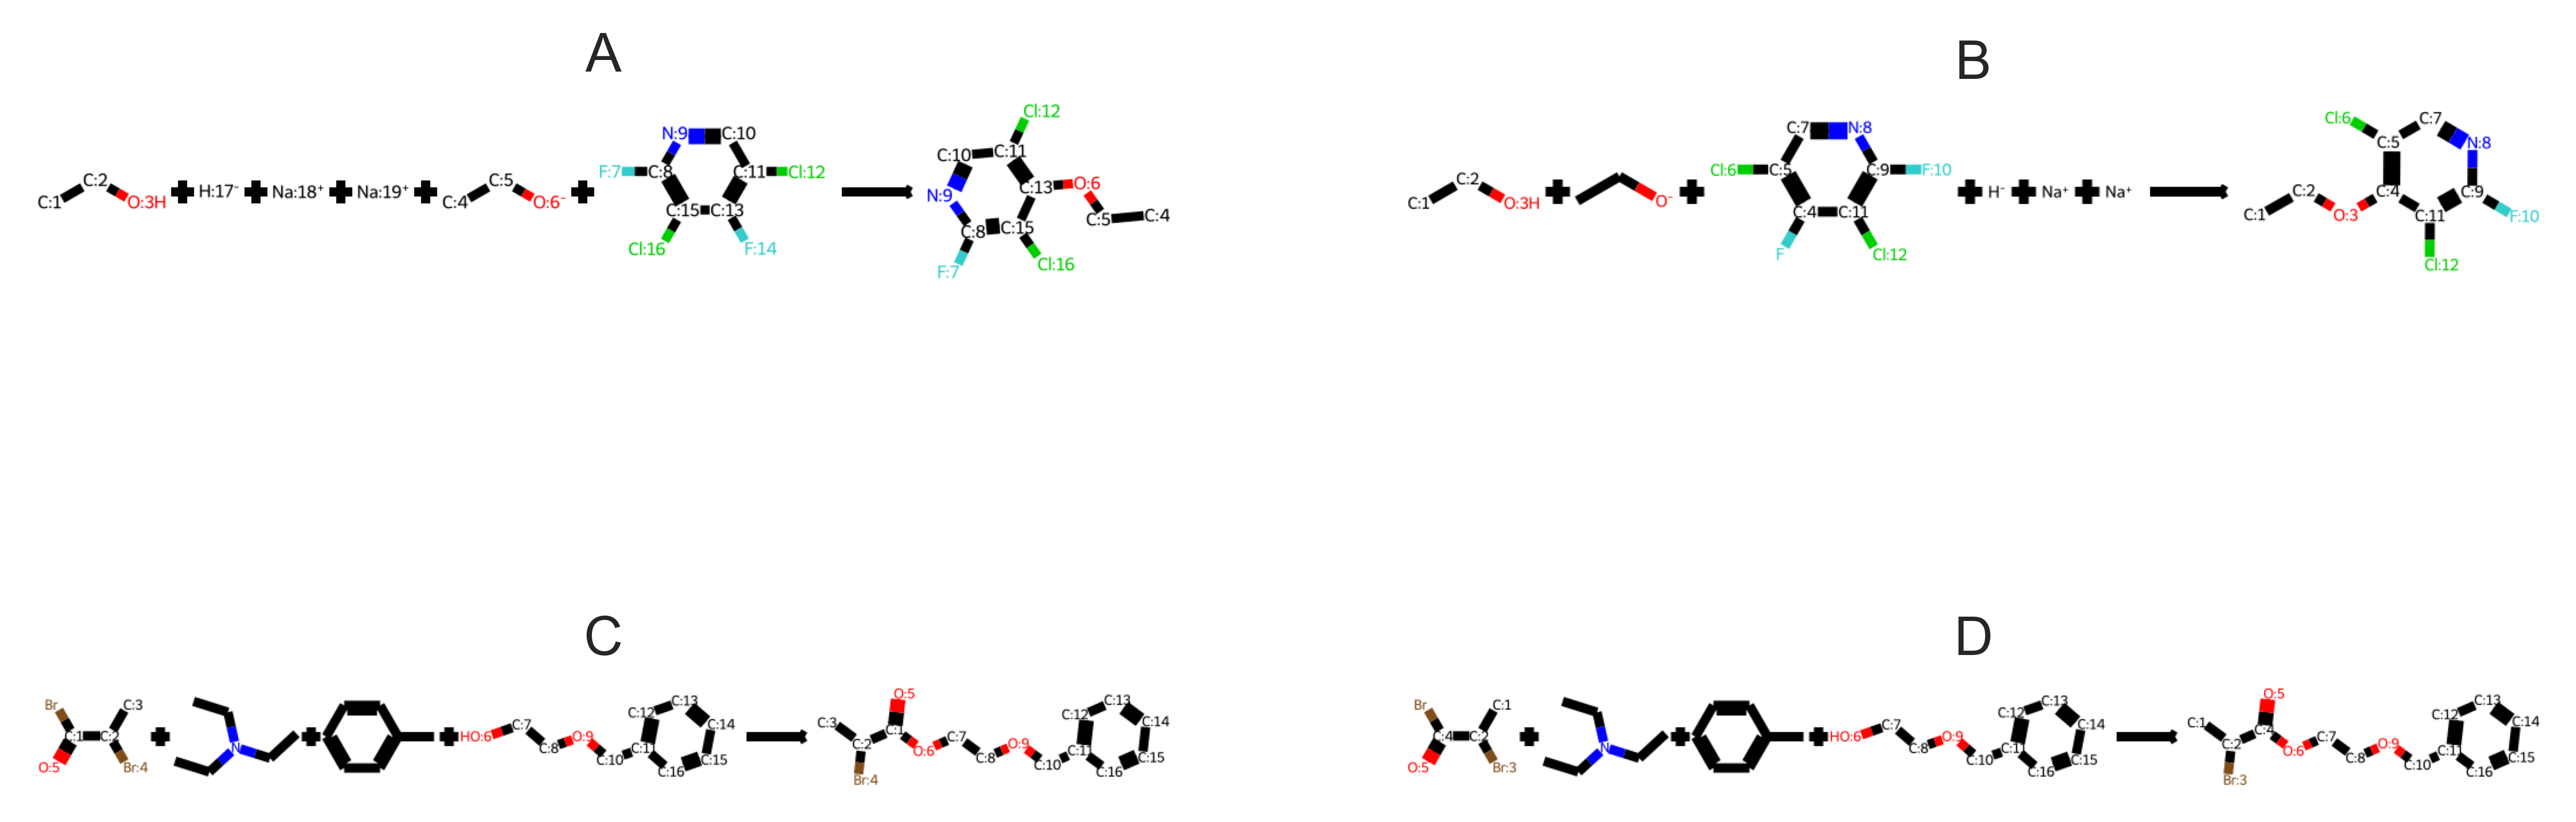

(<Figure size 6000x2400 with 4 Axes>,
 array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'B'}>],
        [<Axes: title={'center': 'C'}>, <Axes: title={'center': 'D'}>]],
       dtype=object))

In [89]:
#from synrbl.SynVis.rxnvis import RxnVis
rxn_vis = RxnVis(nrows=2, ncols=2, cairosize=(3000, 1000), border=10, figsize=(10,4), dpi=600)
rxn_vis.plot(reaction_smiles, subtitles, savefig='./Fig/benchmark_dif.pdf', )

## 1.4. Analyze difference from CGRTool

In [128]:
old_rxn = df_old[df_old['CGRTool_rxnmapper'] != data_check['results'][0]]
old_graph = df_old[df_old['CGRTool_graphmapper'] != data_check['results'][1]]

new_rxn = df_new[df_new['CGRTool_rxnmapper'] != data_check['results'][0]]
new_local = df_new[df_new['CGRTool_localmapper'] != data_check['results'][2]]

In [144]:
def op_results(bool):
    if bool:
        return False
    else:
        return True

In [ ]:
data_1  = old_rxn[['RXNMapper', 'CGRTool_rxnmapper', 'GroundTruth']]
data_1.rename(columns ={'RXNMapper': 'Mapped', 'CGRTool_rxnmapper': 'CGRTool'}, inplace = True)
data_1['SynTemp'] = data_1['CGRTool'].apply(op_results)


data_2  = old_graph[['GraphMapper', 'CGRTool_graphmapper', 'GroundTruth']]
data_2.rename(columns ={'GraphMapper': 'Mapped', 'CGRTool_graphmapper': 'CGRTool'}, inplace = True)
data_2['SynTemp'] = data_2['CGRTool'].apply(op_results)


data_3  = new_rxn[['RXNMapper', 'CGRTool_rxnmapper', 'GroundTruth']]
data_3.rename(columns ={'RXNMapper': 'Mapped', 'CGRTool_rxnmapper': 'CGRTool'}, inplace = True)
data_3['SynTemp'] = data_3['CGRTool'].apply(op_results)

data_4  = new_local[['LocalMapper', 'CGRTool_localmapper', 'GroundTruth']]
data_4.rename(columns ={'LocalMapper': 'Mapped', 'CGRTool_localmapper': 'CGRTool'}, inplace = True)
data_4['SynTemp'] = data_4['CGRTool'].apply(op_results)

In [172]:
all_data = pd.concat([data_1, data_2, data_3, data_4], axis=0)
all_data = all_data.drop_duplicates(subset=['Mapped'])
all_data.shape

(183, 4)

In [174]:
test = all_data.to_dict('records')

In [206]:
save_database(test, '../../Data/AAM/cgrtool_benchmark/cgr_diff.json.gz')

In [189]:
from synrbl.SynVis import save_reactions_to_pdf
save_reactions_to_pdf(test, old_reaction_col='GroundTruth', new_reaction_col='Mapped',
                      pdf_filename = '../../Data/AAM/cgrtool_benchmark/cgr_diff.pdf', compare = True, show_atom_numbers=True, orientation = 'vertical')

Saved reactions to ../../Data/AAM/cgrtool_benchmark/cgr_diff.pdf


In [31]:
df_old.iloc[2157,:]['LocalMapper']

'Br[C:1]([CH:2]([CH3:3])[Br:4])=[O:5].CCN(CC)CC.Cc1ccccc1.[OH:6][CH2:7][CH2:8][O:9][CH2:10][c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[C:1]([CH:2]([CH3:3])[Br:4])(=[O:5])[O:6][CH2:7][CH2:8][O:9][CH2:10][c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1'